In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Datset Preperation

In [2]:
# Download Training Dataset
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
#     -O ./horse-or-human.zip

In [3]:
# Download Validation Dataset
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
#     -O ./validation-horse-or-human.zip

In [4]:
# # Extract Dataset
# local_zip = './horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./horse-or-human')
# local_zip = './validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./validation-horse-or-human')
# zip_ref.close()

In [5]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']
['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']
['horse1-204.png', 'horse2-112.png', 'horse3-498.png', 'horse5-032.png', 'horse5-018.png', 'horse1-170.png', 'horse5-192.png', 'horse1-411.png', 'horse4-232.png', 'horse3-070.png']
['valhuman04-20.png', 'valhuman03-01.png', 'valhuman04-08.png', 'valhuman03-15.png', 'valhuman01-04.png', 'valhuman01-10.png', 'valhuman01-11.png', 'valhuman01-05.png', 'valhuman03-14.png', 'valhuman03-00.png']


In [7]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


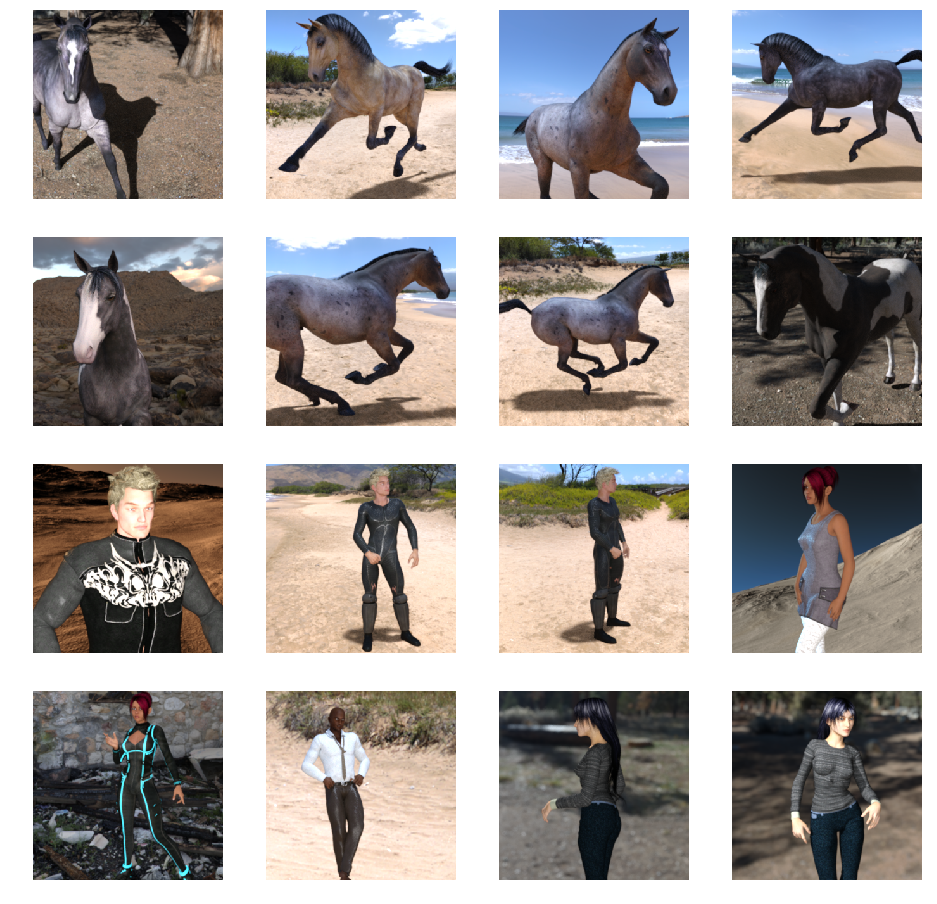

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### Preparing Dataset using tf.data API

In [9]:
# Load the Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory('./horse-or-human/',
                                                              batch_size=32, 
                                                              image_size=(150, 150),
                                                              label_mode='binary')

val_ds = tf.keras.preprocessing.image_dataset_from_directory('./validation-horse-or-human/',
                                                              batch_size=32, 
                                                              image_size=(150, 150),
                                                              label_mode='binary')

# Normalize Images
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [10]:
# Load Data efficiently using tf.data API
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Test Input Image and Label batch size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32, 1)


## Model Definition

In [12]:
# Model Definition
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [14]:
# Compile the Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# # Train the Model
# history = model.fit(train_generator, steps_per_epoch=8, epochs=15, verbose=1,
#       validation_data = validation_generator, validation_steps=8,
#       workers=4, use_multiprocessing=True)

In [16]:
# Train the Model
history = model.fit(train_ds, steps_per_epoch=8, epochs=15, verbose=1,
      validation_data = val_ds, validation_steps=8,
      workers=4, use_multiprocessing=True)

Epoch 1/15
8/8 [==============================] - 2s 271ms/step - loss: 0.6776 - accuracy: 0.5977 - val_loss: 0.6514 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 1s 182ms/step - loss: 0.5884 - accuracy: 0.6836 - val_loss: 0.5052 - val_accuracy: 0.7578
Epoch 3/15
8/8 [==============================] - 1s 177ms/step - loss: 0.3289 - accuracy: 0.8867 - val_loss: 0.7480 - val_accuracy: 0.8242
Epoch 4/15
8/8 [==============================] - 1s 186ms/step - loss: 0.2807 - accuracy: 0.9023 - val_loss: 0.4871 - val_accuracy: 0.8672
Epoch 5/15
8/8 [==============================] - 1s 175ms/step - loss: 0.2642 - accuracy: 0.8767 - val_loss: 1.1781 - val_accuracy: 0.7969
Epoch 6/15
8/8 [==============================] - 1s 169ms/step - loss: 0.2277 - accuracy: 0.9023 - val_loss: 0.5541 - val_accuracy: 0.8594
Epoch 7/15
8/8 [==============================] - 1s 160ms/step - loss: 0.1656 - accuracy: 0.9336 - val_loss: 0.8546 - val_accuracy: 0.8281
Epoch 8/15
8/8 [====

As we can see, the model is overfitting, training accuracy >> validation accuracy.

## Visualizing Convolution Outputs

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


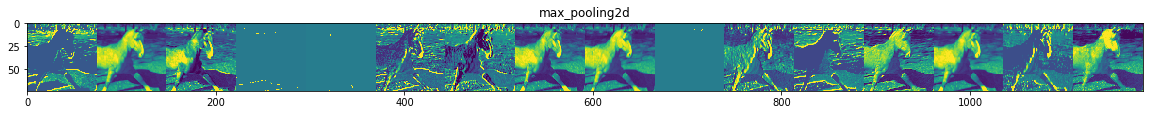

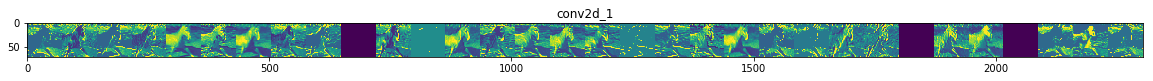

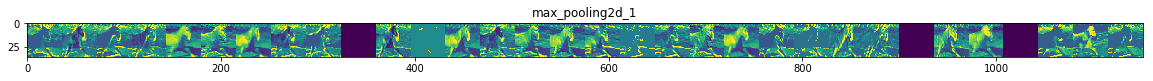

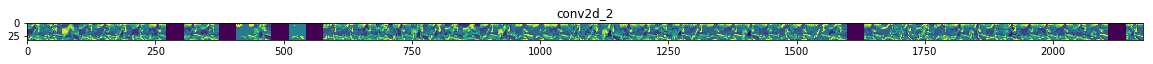

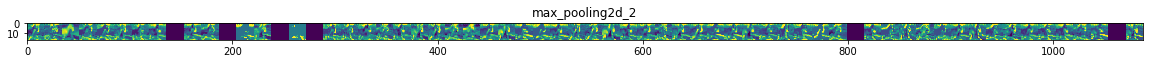

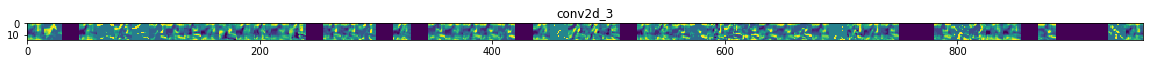

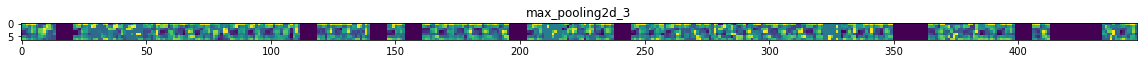

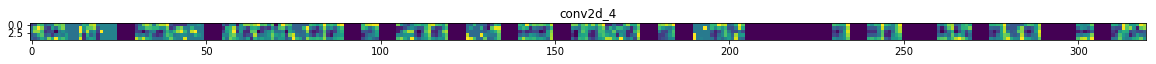

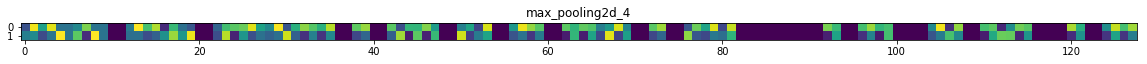

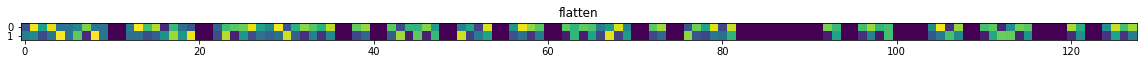

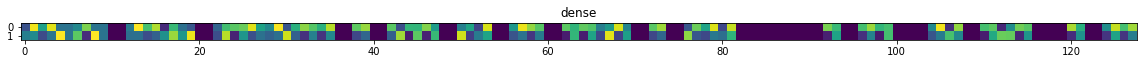

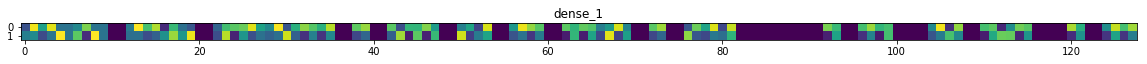

In [18]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')